In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import math
import os
import sys
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.interpolate import BSpline

In [50]:
class Net(nn.Module):
    def __init__(self, num_feat, num_units, num_classes, classes):
        super(Net, self).__init__()
        # print('feats %d' % num_feat)
        # print('units %d' % num_units)
        # print('num_classes %d' % num_classes)
        self.fc1 = nn.Linear(num_feat, num_units)
        self.fc2 = nn.Linear(num_units, num_units)
        self.fc3 = nn.Linear(num_units, num_classes)
        self.expect = torch.from_numpy(classes).float()
        self.expect.requires_grad_(False)
        self.expect = self.expect.view(-1, 1)

    def forward(self, x):
        x = self.fc1(x)
        # print(x.size())
        x = F.relu(x)
        x = self.fc2(x)
        # print(x.size())
        x = F.relu(x)
        x = self.fc3(x)
        # print(x.size())
        x = F.softmax(x, dim=1)
        # print(x)
        # print(x.size())
        # print(self.expect.size())
        x = torch.mm(x, self.expect)
        return x

# Second Seller Turn Model
## Raw Training Curve
Error settles around 3k

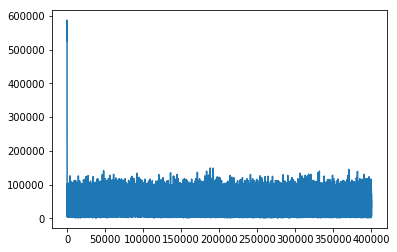

In [37]:
with open('data/models/mvp1/loss_b1.pickle', 'rb') as f:
    loss = pickle.load(f)
    f.close()
xmax = 400000
x = np.array(list(range(xmax)))
loss = [float(curr_loss) for curr_loss in loss]
loss = loss[:xmax]
loss = np.array(loss)
plt.plot(x, loss)
plt.show()

## Smoothed Training Curve

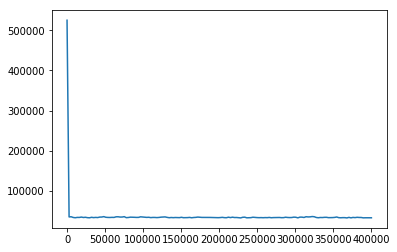

In [39]:
xnew = np.linspace(x.min(), x.max(), 150)
avg = []
prev = 0
for currx in xnew:
    portion = loss[int(prev):(int(currx) + 1)]
    avg.append(portion.mean())
    prev = int(currx)
avg = np.array(avg)
# final error is around 3k
plt.plot(xnew, avg)
plt.show()

## Baseline Comparison on Test Set
Baseline: Predict the midpoint between seller's first offer and buyer's second offer

In [65]:
train = pd.read_csv('data/curr_exp/b1/train_concat.csv')
classes = np.unique(train['offr_s1'].values)
num_classes = classes.size
train.drop(columns=['offr_s1'], inplace = True)
num_feats = len(train.columns)
del train
b1model_dict = torch.load('data/models/mvp1/model_b1.pth.tar')
b1model = Net(num_feats, 100, num_classes, classes)
b1model.load_state_dict(b1model_dict)

test_set = pd.read_csv('data/curr_exp/b1/test-1.csv')
criterion = nn.MSELoss(size_average=True, reduce=True)
loss = criterion

In [66]:
# get baseline predictions
ground_truth = test_set['offr_s1'].values
byr = test_set['offr_b1'].values
slr = test_set['offr_s0'].values
baseline_pred = (byr + slr) / 2
baseline_pred = torch.from_numpy(baseline_pred).float()
ground_truth = torch.from_numpy(ground_truth).float()

In [67]:
# get model predicitons
test_set.drop(columns=['offr_s1'], inplace=True)
test_set = torch.from_numpy(test_set.values).float()
mod_pred = b1model(test_set)

In [68]:
# loss comparison
base_loss = criterion(baseline_pred, ground_truth)
mod_pred = mod_pred.view(-1)
mod_loss = criterion(mod_pred, ground_truth)
print('Baseline Loss: %d' % base_loss)
print('Model Loss: %d' % mod_loss)

Baseline Loss: 1549
Model Loss: 26436


# Third Seller Turn Model
## Raw Training Curve
Error settles around 3k

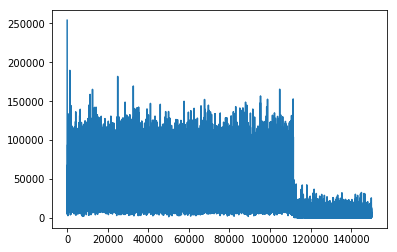

In [57]:
with open('data/models/mvp1/loss_b2.pickle', 'rb') as f:
    loss = pickle.load(f)
    f.close()
xmax = 150000
x = np.array(list(range(xmax)))
loss = [float(curr_loss) for curr_loss in loss]
loss = loss[:xmax]
loss = np.array(loss)
plt.plot(x, loss)
plt.show()

## Smoothed Training Curve

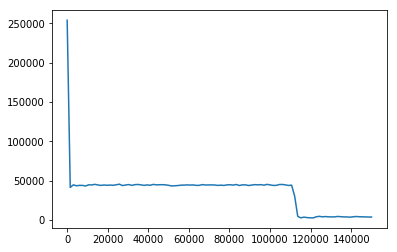

In [58]:
xnew = np.linspace(x.min(), x.max(), 100)
avg = []
prev = 0
for currx in xnew:
    portion = loss[int(prev):(int(currx) + 1)]
    avg.append(portion.mean())
    prev = int(currx)
avg = np.array(avg)
plt.plot(xnew, avg)
plt.show()

## Baseline Comparison on Test Set
Baseline: Predict the midpoint between seller's first offer and buyer's second offer

In [61]:
train = pd.read_csv('data/curr_exp/b2/train_concat.csv')
classes = np.unique(train['offr_s2'].values)
num_classes = classes.size
train.drop(columns=['offr_s2'], inplace = True)
num_feats = len(train.columns)
del train
b1model_dict = torch.load('data/models/mvp1/model_b2.pth.tar')
b1model = Net(num_feats, 100, num_classes, classes)
b1model.load_state_dict(b1model_dict)

test_set = pd.read_csv('data/curr_exp/b2/test-1.csv')
criterion = nn.MSELoss(size_average=True, reduce=True)
loss = criterion

In [62]:
# get baseline predictions
ground_truth = test_set['offr_s2'].values
byr = test_set['offr_b2'].values
slr = test_set['offr_s1'].values
baseline_pred = (byr + slr) / 2
baseline_pred = torch.from_numpy(baseline_pred).float()
ground_truth = torch.from_numpy(ground_truth).float()

In [63]:
# get model predicitons
test_set.drop(columns=['offr_s2'], inplace=True)
test_set = torch.from_numpy(test_set.values).float()
mod_pred = b1model(test_set)

In [64]:
# loss comparison
base_loss = criterion(baseline_pred, ground_truth)
mod_pred = mod_pred.view(-1)
mod_loss = criterion(mod_pred, ground_truth)
print('Baseline Loss: %d' % base_loss)
print('Model Loss: %d' % mod_loss)

Baseline Loss: 1516
Model Loss: 16828
